# Model evaluation

Import relevant libraries

In [1]:
import pathlib
import os
import datetime
import json

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import xarray as xr
import cartopy.crs as ccrs

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

In [6]:
import prd_pipeline

AzureML libraries not found, using local execution functions.


In [7]:
import mlflow
mlflow.tensorflow.autolog()

### Set up MLFlow and load pretrained model

In [8]:
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns


In [9]:
run_id = 'a3360154e69047af8933fe4c44974f40'
trained_model = mlflow.keras.load_model(f'runs:/{run_id}/model')
trained_model.summary()

2022-11-29 11:13:23.284423: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 5)]      0           []                               
                                                                                                  
 zero_padding1d_3 (ZeroPadding1  (None, 35, 5)       0           ['profile_input[0][0]']          
 D)                                                                                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 33, 32)       480         ['zero_padding1d_3[0][0]']       
                                                                                                  
 zero_padding1d_4 (ZeroPadding1  (None, 35, 32)      0           ['conv1d_3[0][0]']         

### Load and preprocess test data

Here we set up some of the data configurations 

In [10]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [11]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

In [12]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity',  'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] #air_pressure',
single_lvl_features = []#['surface_altitude']#'thickness_of_rainfall_amount', 'surface_altitude', 'air_pressure_at_sea_level', 'cloud_area_fraction'

In [13]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 

In [14]:
data_dims_dict = {
    'nprof_features': len(profile_features), 
    'nheights': 33, 
    'nsinglvl_features': len(single_lvl_features), 
    'nbands': len(bands)
}

Then load the test scenario dataset into pandas DataFrames. Here, test_scenario can currently be set to either 'storm_ellen' or 'storm_eunice_franklin' (but can be set to any event name that has been left out of the model training dataset)

In [15]:
test_scenario_name = 'storm_eunice_franklin' 

In [16]:
dataset_dir = '/project/informatics_lab/precip_rediagnosis/train202210'
dataset_dir = pathlib.Path(dataset_dir)

prd_path_list = [p1 for p1 in dataset_dir.rglob(f'{prd_pipeline.MERGED_PREFIX}*{prd_pipeline.CSV_FILE_SUFFIX}')]
test_scenario_filepath = [event for event in prd_path_list if test_scenario_name in str(event)][0]

In [17]:
test_scenario = pd.read_csv(test_scenario_filepath)

### Data prep on test scenario dataset
- Calculate NWP probabilities (to be moved into data prep pipeline!)
- Run data preprocessing on the pandas dataframe containing NWP probabilities. When NWP calc moved into data prep, the test scenario file can be the input to preprocess_test_data, as well as pandas dataframe. 
- Create an evaluation dataframe that contains radar, NWP and ML predicted fractions, as well as associated metadata. This dataframe is used for plotting of predictions. 

In [18]:
nwp_precip_vars = [col for col in test_scenario.columns if 'rate' in col]
test_scenario['nwp_precip_rate'] = test_scenario[nwp_precip_vars].sum(axis=1)

In [19]:
def calc_nwp_probabilities(data, lower_bound, upper_bound):
    return ((data>=lower_bound) & (data<upper_bound)).sum()/data.shape[0]

In [20]:
nwp_fractions = [
    test_scenario.groupby(['latitude', 'longitude', 'time'])[['nwp_precip_rate']].apply(
        lambda x: calc_nwp_probabilities(x, lower_bound, upper_bound)).rename(columns={'nwp_precip_rate':intensity_band_template.format(source='mogrepsg', band_centre=intensity_band)})
    for intensity_band, [lower_bound, upper_bound] in bands.items()]
nwp_prob_df = pd.concat(nwp_fractions, axis=1)
test_scenario = pd.merge(test_scenario, nwp_prob_df, left_on=['latitude', 'longitude', 'time'], right_index=True)

In [21]:
data_splits_test = prd_pipeline.preprocess_test_data(test_scenario, feature_dict, data_dims_dict)

In [22]:
ypred_test = trained_model.predict(data_splits_test['X_test'])
pred_column_names = [intensity_band_template.format(source='ml', band_centre=threshold) for threshold in bands.keys()]
ypred_test_df = pd.DataFrame(ypred_test, columns=pred_column_names)

2022-11-29 11:14:53.397017: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 229188960 exceeds 10% of free system memory.


In [23]:
test_scenario_evaluation_df = pd.concat([
    data_splits_test['meta'],
    ypred_test_df,
    data_splits_test['y_test'],
    data_splits_test['nwp_test']], axis=1)

In [24]:
source = ['radar', 'mogrepsg', 'ml']
for src in source:
    test_scenario_evaluation_df = prd_pipeline.calculate_p_exceedance(test_scenario_evaluation_df, src, bands, intensity_band_template)

### Visualise forecast

Visual ML fraction prediction and compare to NWP forecast probabilities and radar fractions

First, we convert the data currently in a pandas dataframe to xarray, taking the mean across realizations. This will not change the NWP or radar data as this is the same for all realizations, so will only be averaging the ML predictions from each of the ensemble members. 

In [25]:
data_xr = test_scenario_evaluation_df.groupby(['time', 'latitude', 'longitude']).agg('mean').drop(columns='realization').to_xarray()

Plot a comparison of a single forecast lead time comparing instantaneous precipiation fractions radar (regridded onto MOGREPS-G grid) with ML model predictions and NWP predictions. Note that the ML predictions here are ensemble averages, which may result in some spatial smoothing. 

In the right hand plots, red indicates that the predictions are greater than radar measurements and blue that the predicted fractions are less than what was observed by the radar.

In [26]:
# for time_idx in range(16):
#     print(time_idx)
#     prd_pipeline.plot_forecast(data_xr, '0.25', 'ml', '0.5', time_idx)
#     prd_pipeline.plot_forecast(data_xr, '0.25', 'mogrepsg', '0.5', time_idx)

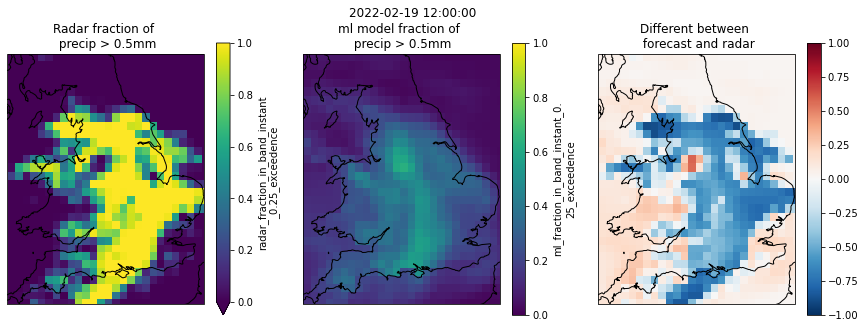

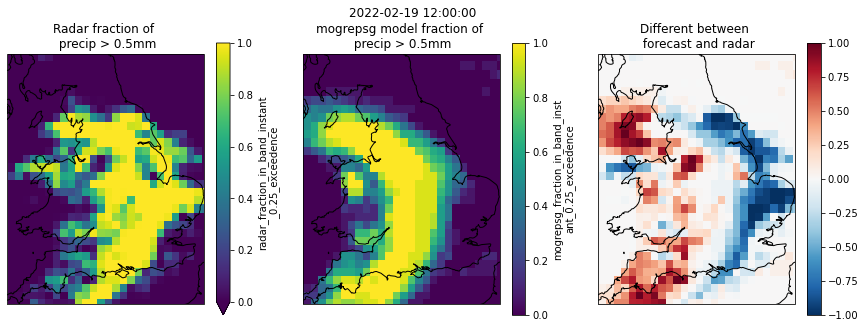

In [43]:
time_idx = 5
prd_pipeline.plot_forecast(data_xr, '0.25', 'ml', '0.5', time_idx)
prd_pipeline.plot_forecast(data_xr, '0.25', 'mogrepsg', '0.5', time_idx)

To understand the ML predictions that make up the average presented in the plot above, postage stamp plots are used to show the different predictions made by the ML model for each ensemble member. 

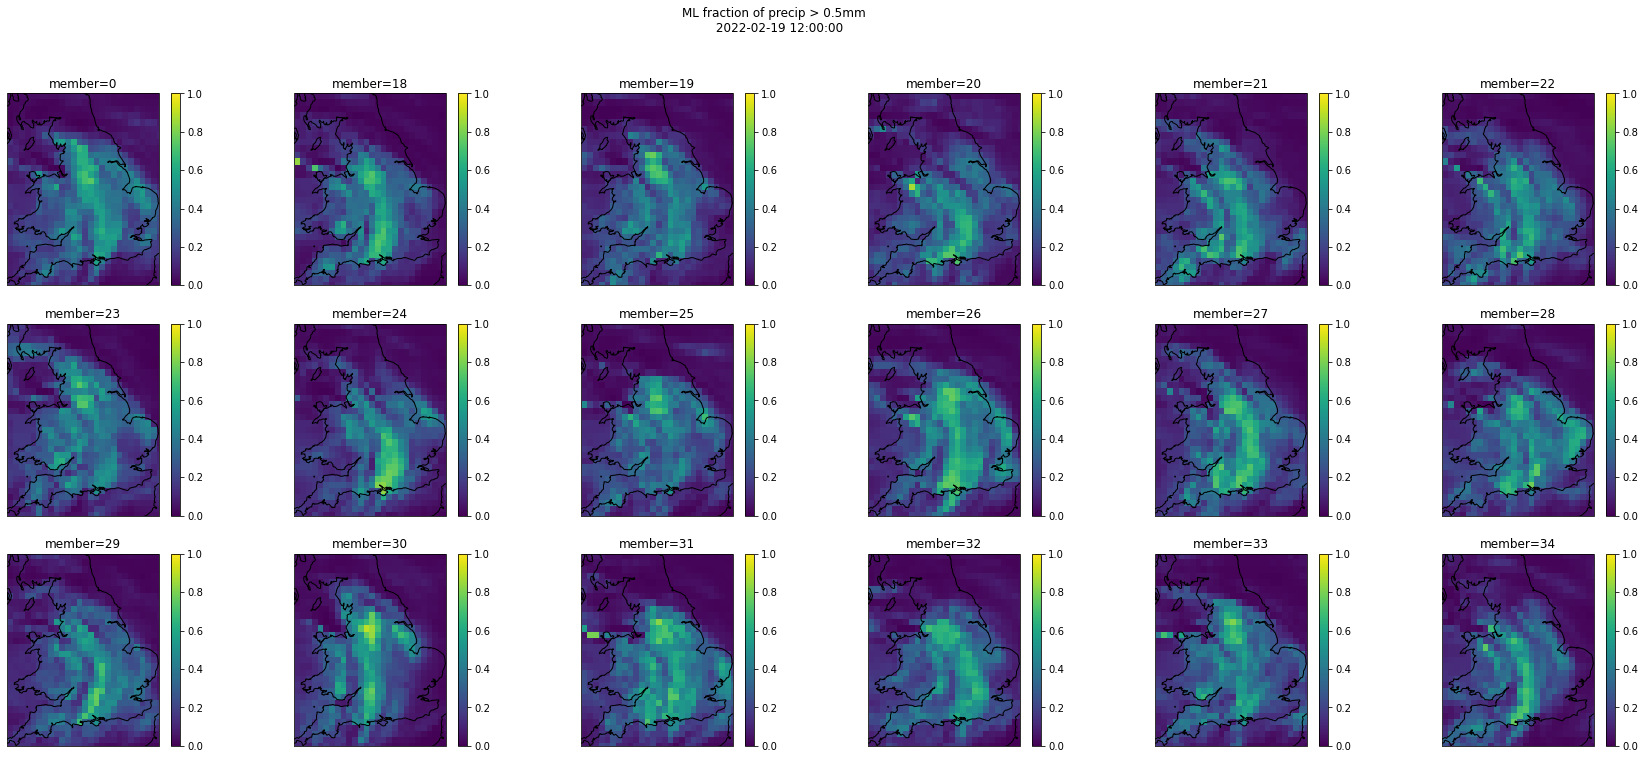

In [44]:
time_idx = 5
threshold = '0.25'
prd_pipeline.postage_stamp_plot(test_scenario_evaluation_df, threshold, time_idx, bands)

In [29]:
intensity_bands = [f'{lower_bound}mm-{upper_bound}mm' for lower_bound, upper_bound in bands.values()]

A line plot is used to show the forecast for an specific location and time. 

Orange shows the NWP probability in each of the precipitation intensity bands. Blue is the Radar fractions in each precip intensity band for this cell and time. Each grey line is showing the different precipication fractions predicted by the ML model for the different ensemble members. The green dashed line is the average of all of the grey lines.

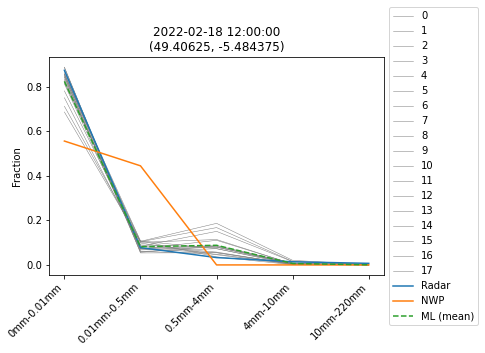

In [30]:
grouped_df = test_scenario_evaluation_df.groupby(['time', 'latitude', 'longitude'])
grouped_df_mean = grouped_df.agg('mean')
group_keys = list(grouped_df.groups.keys())
for i in np.arange(1):
    test_scenario_evaluation_df.iloc[grouped_df.groups[group_keys[i]]][pred_column_names].T.plot(lw=0.5, color='grey', label='_nolegend_')
    
    grouped_df_mean.iloc[i][feature_dict['target']].plot(label='Radar')
    grouped_df_mean.iloc[i][feature_dict['nwp']].plot(label='NWP')
    grouped_df_mean.iloc[i][pred_column_names].plot(label='ML (mean)', ls='--')
    
    plt.ylabel('Fraction')
    plt.xticks(np.arange(5), intensity_bands, rotation=45, ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'{group_keys[i][0]}\n{group_keys[i][1:]}')
    
    plt.show()

### Fractional skill score

The fractional skill score (FSS) is a verification metric often used to assess the performance of a probabilistic precipitation forecast. It allows comparison of predicted precipitation values to precipitions observed by radar, our source of truth.

Note: Fractional skill scores are calculated on probabilities of exceeding thresholds, so we convert our discrete probability distributions (i.e. fractions in different intensity bands) to a cumulative distribution function. This is done within the calculate metric function if 'fss' is provided for the metric argument. 

Firstly we calculate the FSS for our entire test scenario dataset. 

FSS where each ML prediction for different NWP ensemble member treated as deterministic 

In [31]:
prd_pipeline.calculate_metric(test_scenario, trained_model, feature_dict, data_dims_dict, metric='fss').round(4)

ml_fss_0.0      0.6719
ml_fss_0.25     0.5608
ml_fss_2.5      0.1936
ml_fss_7.0      0.0136
ml_fss_10.0     0.0000
nwp_fss_0.0     0.6802
nwp_fss_0.25    0.6586
nwp_fss_2.5     0.1772
nwp_fss_7.0     0.0080
nwp_fss_10.0    0.0420
dtype: float64

FSS where the ML predictions are the mean of the set of ML prediction from NWP ensemble members

In [32]:
grouped = test_scenario.groupby(['time', 'latitude', 'longitude']).agg('mean')
prd_pipeline.calculate_metric(grouped.reset_index(), trained_model, feature_dict, data_dims_dict, metric='fss').round(4)

ml_fss_0.0      0.6839
ml_fss_0.25     0.5828
ml_fss_2.5      0.2281
ml_fss_7.0      0.0136
ml_fss_10.0     0.0000
nwp_fss_0.0     0.6802
nwp_fss_0.25    0.6585
nwp_fss_2.5     0.1772
nwp_fss_7.0     0.0080
nwp_fss_10.0    0.0367
dtype: float64

FSS where the ML predictions are only using control member of the NWP ensemble

In [33]:
prd_pipeline.calculate_metric(test_scenario[test_scenario['realization']==0], trained_model, feature_dict, data_dims_dict, metric='fss').round(4)

ml_fss_0.0      0.6879
ml_fss_0.25     0.5719
ml_fss_2.5      0.1888
ml_fss_7.0      0.0125
ml_fss_10.0     0.0000
nwp_fss_0.0     0.6802
nwp_fss_0.25    0.6586
nwp_fss_2.5     0.1772
nwp_fss_7.0     0.0080
nwp_fss_10.0    0.0420
dtype: float64

### Plot fractional skill score for each grid cell on map

To understand whether the performance of the the ML model is consistant across the domain, the test scenario dataset is grouped by latitude and longitude, allowing the FSS for each grid cell to be calculated. This information is then presented on a map comparing the FSS for NWP and ML predicted values. 

Again, there is the options to either treat each ensemble member as a deterministics forecast, to average the the ML predictions from each ensemble member or to only use the ML prediction based on the NWP control forecast.

In [34]:
ml_prediction_acc = 'deterministic'

In [35]:
if ml_prediction_acc == 'deterministic':
    fss_grid = test_scenario.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='fss'))
if ml_prediction_acc == 'average':
    grid_grouped_df = test_scenario.groupby(['time', 'latitude', 'longitude']).agg('mean').reset_index()
    fss_grid = grid_grouped_df.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='fss'))
if ml_prediction_acc == 'control':
    fss_grid = test_scenario[test_scenario.realization==0].groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='fss'))

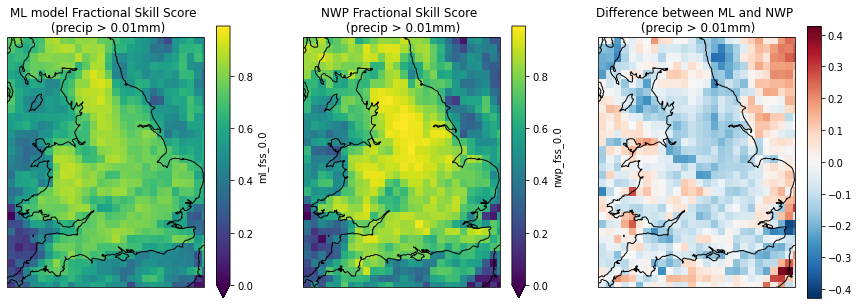

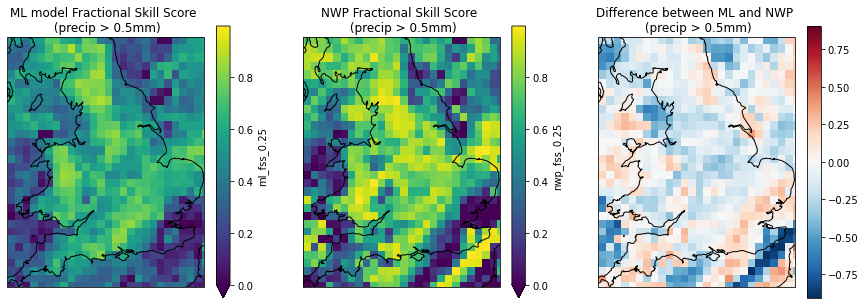

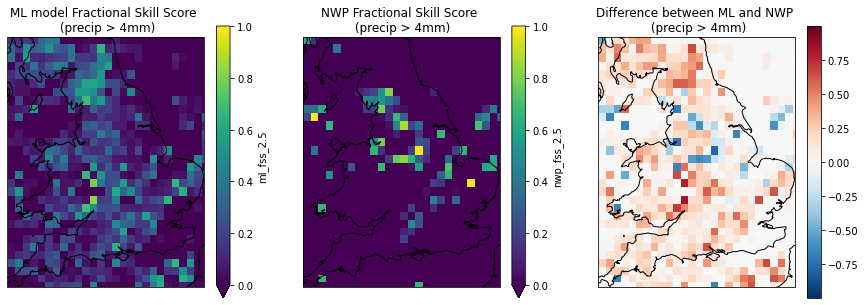

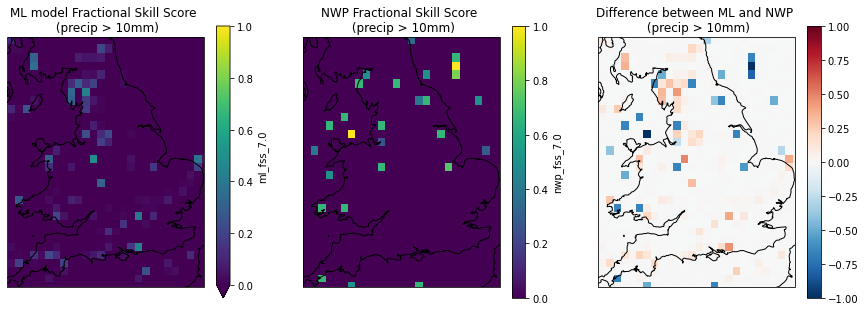

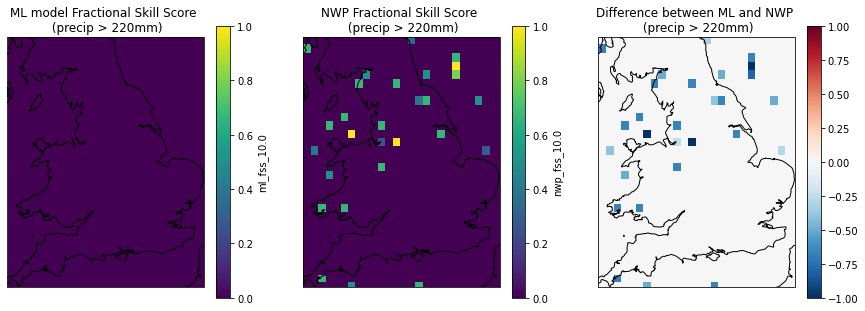

In [36]:
for intensity_band_centre, (lower_bound, upper_bound) in bands.items():
    fig, ax = prd_pipeline.plot_metric_on_map(
        fss_grid.fillna(0).to_xarray(), threshold=intensity_band_centre, metric='fss')
    
    ax[0].set_title(f'ML model Fractional Skill Score \n (precip > {upper_bound}mm)')
    ax[1].set_title(f'NWP Fractional Skill Score \n (precip > {upper_bound}mm)')
    ax[2].set_title(f'Difference between ML and NWP \n (precip > {upper_bound}mm)')
    plt.show()

Now we have a grid of FSS values, we can also calculate the domain average FSS. 

In [37]:
fss_grid.mean().round(4)

ml_fss_0.0      0.5943
ml_fss_0.25     0.4406
ml_fss_2.5      0.1115
ml_fss_7.0      0.0129
ml_fss_10.0     0.0000
nwp_fss_0.0     0.6144
nwp_fss_0.25    0.5281
nwp_fss_2.5     0.0509
nwp_fss_7.0     0.0278
nwp_fss_10.0    0.0301
dtype: float64

### Frequency bias

The frequency bias is is the ratio between predicted fractions and observed fractions in each precipitation intensity band. This allows us to understand when the model is under or over predicting the fractions in each intensity band. 

- freq_bias = 0 indicates fx=0 and obs>0 
- 0 < freq_bias < 1 indicates fx < obs
- freq_bias = 1 (or close) fx == obs (or almost)
- freq_bias > 1 indicates fx > obs
- freq_bias = inf when obs=0

A very large frequency bias indicates fx >> obs (or very small obs value)


In [45]:
prd_pipeline.calculate_metric(test_scenario, trained_model, feature_dict, data_dims_dict, metric='freq_bias')

ml_freq_bias_0.0      3.041244
ml_freq_bias_0.25     4.962091
ml_freq_bias_2.5      4.724281
ml_freq_bias_7.0      1.612861
ml_freq_bias_10.0     0.130059
nwp_freq_bias_0.0     1.778101
nwp_freq_bias_0.25    8.998413
nwp_freq_bias_2.5     4.187887
nwp_freq_bias_7.0     0.948812
nwp_freq_bias_10.0    0.005048
dtype: float64

### Plot frequency bias for each grid cell on a map

As with FSS, we plot the frequency bias on a map to understand any spatial distribution of model performance. 

Note: In the plots for ML and NWP frequency bias, we use a log scale. Also NaN values (where obs=0) are replaced with a fill value of 10000 and show up as yellow in the plot.


In [46]:
if ml_prediction_acc == 'deterministic':
    freq_bias_grid = test_scenario.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='freq_bias'))
if ml_prediction_acc == 'average':
    grid_grouped_df = test_scenario.groupby(['time', 'latitude', 'longitude']).agg('mean').reset_index()
    freq_bias_grid = grid_grouped_df.groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='freq_bias'))
if ml_prediction_acc == 'control':
    freq_bias_grid = test_scenario[test_scenario.realization==0].groupby(['latitude', 'longitude']).apply(
        lambda x: prd_pipeline.calculate_metric(x, trained_model, feature_dict, data_dims_dict, metric='freq_bias'))

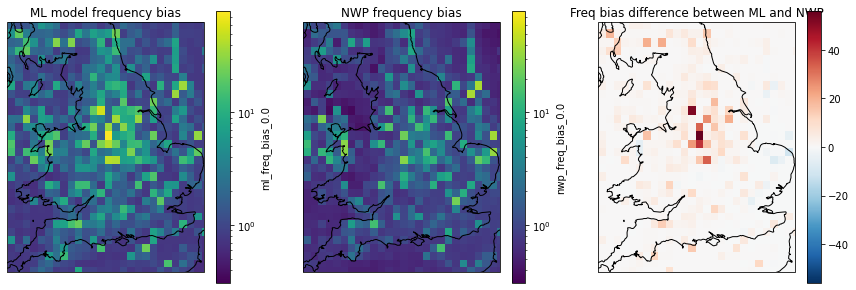

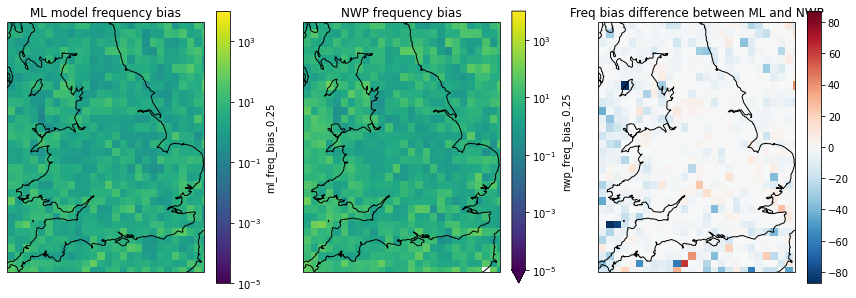

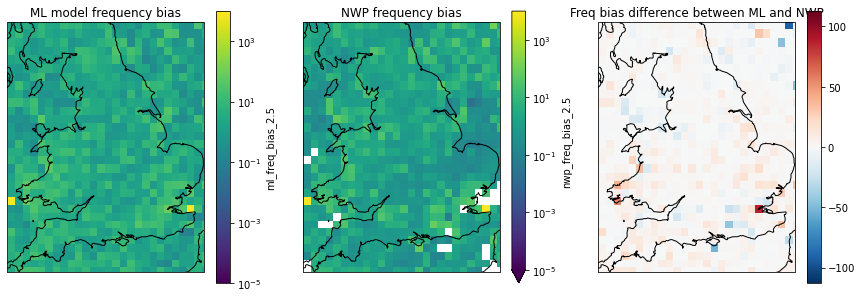

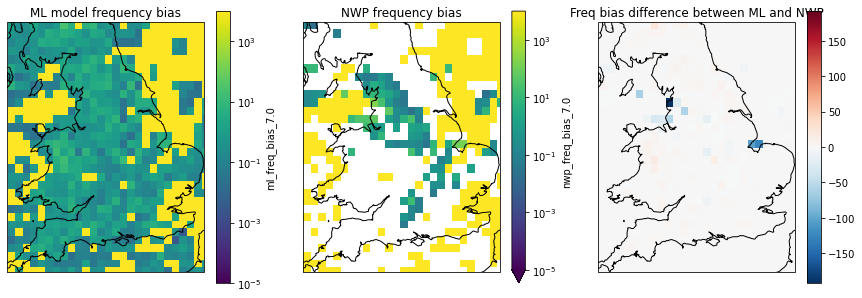

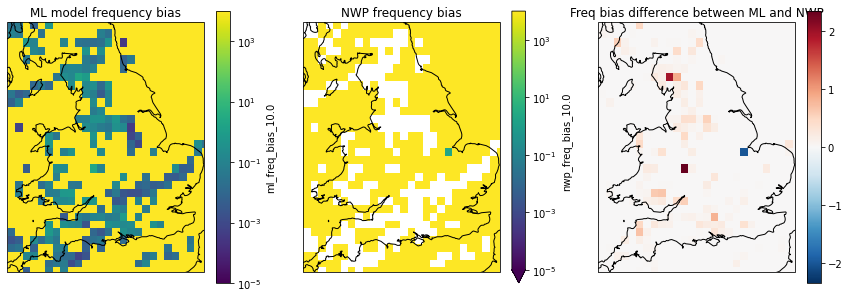

In [47]:
for band in bands.keys():
    threshold=band
    fig, ax = prd_pipeline.plot_metric_on_map(
        freq_bias_grid.fillna(10000).to_xarray(), threshold, metric='freq_bias' )
    
    ax[0].set_title(f'ML model frequency bias')
    ax[1].set_title(f'NWP frequency bias')
    ax[2].set_title(f'Freq bias difference between ML and NWP')
    plt.show()

Now we have a grid of frequency bias values, we can also calculate the domain average frequency bias. 

In [48]:
freq_bias_grid.mean()

ml_freq_bias_0.0      3.146447
ml_freq_bias_0.25     5.606595
ml_freq_bias_2.5      4.933447
ml_freq_bias_7.0      1.297371
ml_freq_bias_10.0     0.121074
nwp_freq_bias_0.0     1.810920
nwp_freq_bias_0.25    9.773856
nwp_freq_bias_2.5     4.627129
nwp_freq_bias_7.0     1.088222
nwp_freq_bias_10.0    0.006474
dtype: float64